In [21]:
# !pip install tqdm

In [19]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from transformers import ViTForImageClassification
from scipy import stats



label_to_int = {'Goed': 0, 'Matig': 1, 'Redelijk': 2, 'Slecht': 3, 'Zeer Slecht': 4}

class CustomImageDataset1(Dataset):
    def __init__(self, images, labels, transforms=None, samples_per_class=None):
        self.images = images
        self.labels = [label_to_int[label] for label in labels]
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        if self.transforms:
            image = self.transforms(image)

        return image, label

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transforms=None, sampling_factors=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.sampling_factors = sampling_factors if sampling_factors is not None else {label: 1 for label in set(labels)}

    def __len__(self):
        # Calculate total length considering sampling factors
        total_length = 0
        for label in self.labels:
            total_length += self.sampling_factors[label]
        return total_length

    def __getitem__(self, idx):
        # Find the actual image index based on the sampling factor
        actual_idx = idx
        for i, label in enumerate(self.labels):
            if actual_idx < self.sampling_factors[label]:
                break
            actual_idx -= self.sampling_factors[label]


        image = Image.open(self.images[i])
        label = self.labels[i]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        # Process image
        if self.transforms:
            image = self.transforms(image)

        return image, label_to_int[label]

def load_images(folder_path):
    print("Loading images...")

    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_folder)
    print("Total images loaded:", len(images))
    return images, labels

def split_dataset(images, labels, train_ratio=0.6, val_ratio=0.2):
    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    train_set = dataset[:train_size]
    val_set = dataset[train_size:train_size + val_size]
    test_set = dataset[train_size + val_size:]
    print(f"Dataset split into {len(train_set)} training, {len(val_set)} validation, and {len(test_set)} test images.")
    return train_set, val_set, test_set

def count_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def calculate_sampling_factors(train_set):
    label_counts = Counter(label for _, label in train_set)
    min_samples = min(label_counts.values())

    # Calculate sampling factor for each class
    sampling_factors = {label: round(min_samples / count) for label, count in label_counts.items()}
    return sampling_factors

def create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size):
    # Define transformations
    print("Creating dataloaders...")

    train_transforms = transforms.Compose([
        transforms.RandomCrop(224),  # Specify size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CustomImageDataset([i[0] for i in train_set], [i[1] for i in train_set], transforms=train_transforms, sampling_factors=sampling_factors)
    val_dataset = CustomImageDataset([i[0] for i in val_set], [i[1] for i in val_set], transforms=val_test_transforms)
    test_dataset = CustomImageDataset([i[0] for i in test_set], [i[1] for i in test_set], transforms=val_test_transforms)
    # print('Dataset', train_dataset[0])
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataloaders created.")
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

def calculate_samples_per_class(class_distribution):
    min_count = min(class_distribution.values())
    samples_per_class = {label_to_int[cls]: min_count // count for cls, count in class_distribution.items()}
    return samples_per_class



def load_data(folder1):
    images, labels = load_images(folder1)
    train_set, val_set, test_set = split_dataset(images, labels)

    # Print class distribution
    train_class_distribution = count_class_distribution(train_set)
    val_class_distribution = count_class_distribution(val_set)
    test_class_distribution = count_class_distribution(test_set)

    print("Training set class distribution:", train_class_distribution)
    print("Validation set class distribution:", val_class_distribution)
    print("Test set class distribution:", test_class_distribution)

    # sampling_factors = calculate_sampling_factors(train_set)
#     sampling_factors = {'rice': 1, 'other': 2, 'sugarcane': 6, 'cassava': 12, 'maize': 10}
    sampling_factors = {'Goed': 7, 'Matig': 7, 'Redelijk': 7, 'Slecht': 7, 'Zeer Slecht': 7}
    print('Sampling factors: ', sampling_factors)
    train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size=8)

    return train_loader, val_loader, test_loader

/mnt/nvme-Samsung_SSD_970_EVO_1TB_S5H9NS0NA91427J-part2/TU/Onedrive/Robotics/CS4240 Deep learning/Project/StreetView-CropType/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def extract_patches(image, patch_size, stride):
    patches = []
    c, height, width = image.size()

    for y in range(0, height - patch_size[1] + 1, stride):
        for x in range(0, width - patch_size[0] + 1, stride):
            patch = image[:, y:y + patch_size[1], x:x + patch_size[0]]
            patches.append(patch)

    return patches

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)

        #For ViT
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels)

        # loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        # _, predicted = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.logits, 1)

        correct = (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct/len(labels))

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        # For F1 score calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    return avg_loss, accuracy, f1, per_class_f1



def validate_or_test(model, loader, criterion, device, patch_size, stride, desc='Val'):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            batch_preds = []

            for image in images:
                # # Apply sliding window approach
                # patches = extract_patches(image, patch_size, stride)
                # patches = torch.stack(patches).to(device)

                # # Aggregate predictions for each patch
                # patch_outputs = model(patches)
                # logits = patch_outputs.logits  # Extract the logits
                # patch_predictions = torch.mean(logits, dim=0)
                # patch_predictions = torch.mean(patch_outputs, dim=0)
                # batch_preds.append(patch_predictions)

                # Calculate the mode of the patch predictions

                patches = extract_patches(image, patch_size, stride)
                patches = torch.stack(patches).to(device)

                # Aggregate predictions for each patch
                patch_outputs = model(patches)
                logits = patch_outputs.logits  # Extract the logits

                # Calculate mode for each patch prediction
                modes, _ = torch.mode(logits, dim=0)
                batch_preds.append(modes)

            print(batch_preds)
            batch_preds = torch.stack(batch_preds)
            loss = criterion(batch_preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(batch_preds, 1)
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return avg_loss, accuracy, f1, per_class_f1

def train_and_evaluate(model, train_loader, val_loader, test_loader, model_name, num_epochs=5, patch_size=(224, 224), stride=30):
    # Criterion, Optimizer, and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    global best_val_f1
    global best_model_weights

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_f1, train_f1_per_class = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Train F1 Score Per Class ', train_f1_per_class)

        val_loss, val_accuracy, val_f1, val_f1_per_class = validate_or_test(model, val_loader, criterion, device, patch_size, stride, desc='Val')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')
        print(f'Val F1 Score Per Class ', val_f1_per_class)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()  # Save the best model weights

        # Save intermediate model weights
        torch.save(model.state_dict(), imagesRoot+f'{model_name}_epoch_{epoch}.pth')

        scheduler.step()


    test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(model, test_loader, criterion, device, patch_size, stride, desc='Test')
    print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
    print(f'Test F1 Score Per Class ', test_f1_per_class)

    # After training is complete, load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model weights
    torch.save(model.state_dict(), imagesRoot+"/weights"+f'{model_name}.pth')
    return model

Loading images...
Total images loaded: 36
Splitting dataset...
Dataset split into 21 training, 7 validation, and 8 test images.
Training set class distribution: {'Goed': 4, 'Matig': 5, 'Zeer Slecht': 4, 'Slecht': 5, 'Redelijk': 3}
Validation set class distribution: {'Zeer Slecht': 1, 'Redelijk': 3, 'Matig': 1, 'Goed': 2}
Test set class distribution: {'Goed': 1, 'Zeer Slecht': 2, 'Slecht': 3, 'Redelijk': 1, 'Matig': 1}
Sampling factors:  {'Goed': 7, 'Matig': 7, 'Redelijk': 7, 'Slecht': 7, 'Zeer Slecht': 7}
Creating dataloaders...
Dataloaders created.
19 1 1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.3735, Accuracy: 0.5646, F1 Score: 0.5647
Train F1 Score Per Class  [0.64       0.5625     0.60465116 0.58536585 0.43636364]


[tensor([-0.4814, -0.1032, -0.9805,  0.2883, -0.1348], device='cuda:0'), tensor([-0.3052, -0.2844, -0.9000,  0.2799, -0.5203], device='cuda:0'), tensor([-0.4509, -0.1552, -0.8442,  0.0285, -0.3066], device='cuda:0'), tensor([-0.5401, -0.1991, -0.9505,  0.2275, -0.0922], device='cuda:0'), tensor([-0.2232,  0.1738, -0.8673, -0.3928, -0.8394], device='cuda:0'), tensor([-0.9387, -0.1833, -0.8705,  0.2320, -0.4972], device='cuda:0'), tensor([-0.6148, -0.2243, -0.7740,  0.0217, -0.2812], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


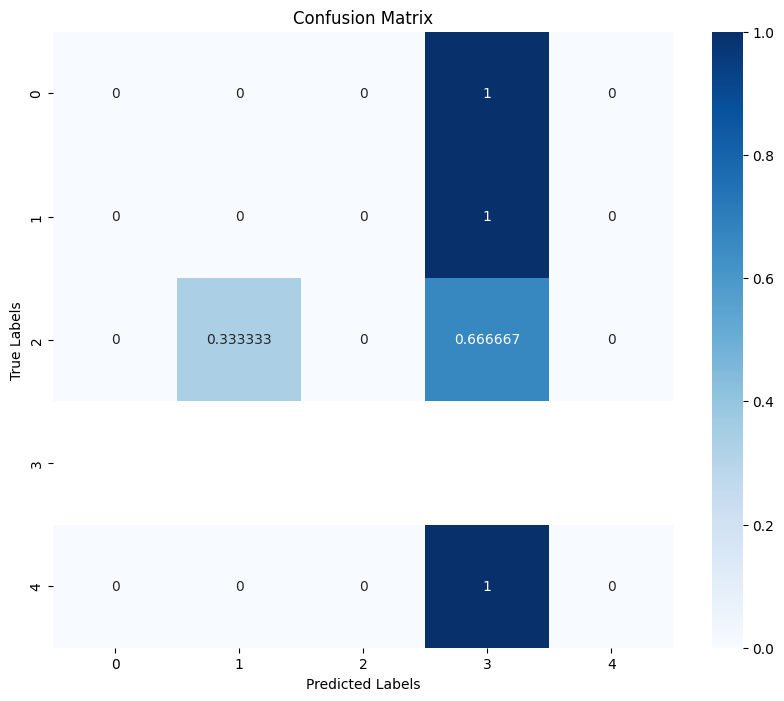

Epoch 1, Validation Loss: 1.9686, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0. 0. 0. 0.]


Epoch 2, Train Loss: 0.7878, Accuracy: 0.8571, F1 Score: 0.8555
Train F1 Score Per Class  [0.89655172 0.87323944 0.9        0.84210526 0.7755102 ]


[tensor([-1.3676, -0.3775, -1.2616, -0.8182, -0.6286], device='cuda:0'), tensor([-0.3666, -0.4192, -1.2344, -0.4376, -0.9471], device='cuda:0'), tensor([-1.2296, -0.7057, -1.1544, -0.6881, -0.8680], device='cuda:0'), tensor([-1.2563, -0.7472, -1.3027, -0.0191,  0.1165], device='cuda:0'), tensor([-0.6086, -0.1264, -1.0774, -0.7461, -1.1021], device='cuda:0'), tensor([-1.3938,  0.5240, -0.8039, -0.5272, -1.1543], device='cuda:0'), tensor([-1.2517, -0.1733, -0.9092, -0.8858, -0.7126], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


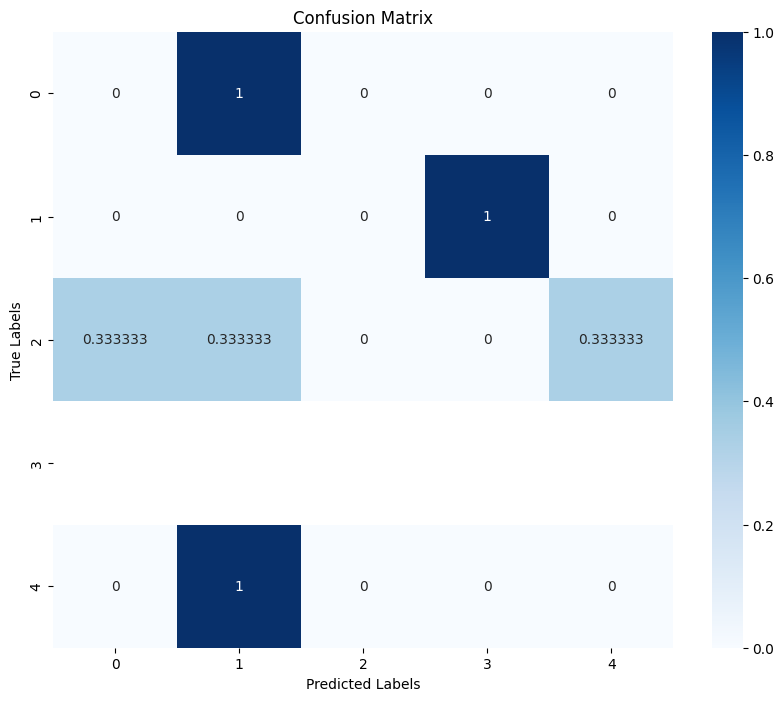

Epoch 2, Validation Loss: 2.0340, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0. 0. 0. 0.]


Epoch 3, Train Loss: 0.3857, Accuracy: 0.9388, F1 Score: 0.9378
Train F1 Score Per Class  [0.92857143 0.97142857 0.95238095 0.95890411 0.86792453]


[tensor([-0.9370, -0.8643, -1.7809, -1.1720, -1.5359], device='cuda:0'), tensor([-0.9727, -0.7385, -0.9980, -0.9647, -1.2522], device='cuda:0'), tensor([-1.1918, -1.5287, -1.4939, -0.8576, -1.4428], device='cuda:0'), tensor([-0.6398, -1.2780, -1.7488, -0.8156, -0.3017], device='cuda:0'), tensor([-0.5303,  0.2340, -0.9985, -1.2760, -1.5742], device='cuda:0'), tensor([-1.6993, -0.8914, -0.8188, -0.7082, -1.5898], device='cuda:0'), tensor([-1.3826, -1.0894, -1.2900, -0.6007, -0.9307], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


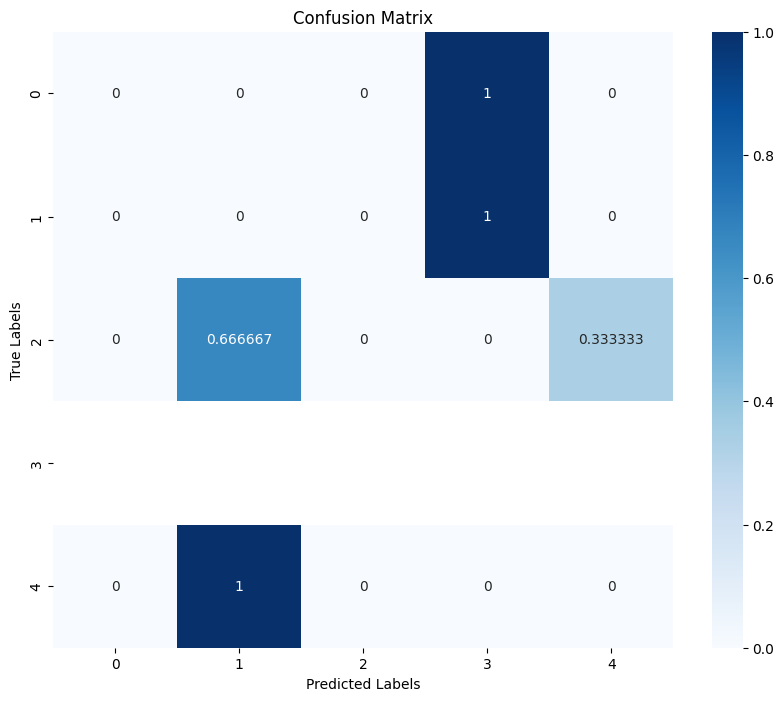

Epoch 3, Validation Loss: 2.0265, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0. 0. 0. 0.]


Epoch 4, Train Loss: 0.3258, Accuracy: 0.9116, F1 Score: 0.9118
Train F1 Score Per Class  [0.9122807  0.91428571 0.8372093  0.92537313 0.94736842]


[tensor([-0.7847, -0.4598, -1.5212, -1.7991, -1.4588], device='cuda:0'), tensor([-1.3375, -0.1063, -1.5368, -0.9529, -1.1886], device='cuda:0'), tensor([-0.7695,  0.9560, -0.8152, -1.7993, -1.6712], device='cuda:0'), tensor([-0.9466, -0.8973, -1.4800, -2.0988, -1.2292], device='cuda:0'), tensor([-1.2504,  2.4121, -1.1755, -0.9028, -1.3999], device='cuda:0'), tensor([-1.7230, -0.8262, -0.7690, -1.3331, -1.5698], device='cuda:0'), tensor([-1.0432, -0.4236, -1.0020, -1.5331, -1.4221], device='cuda:0')]


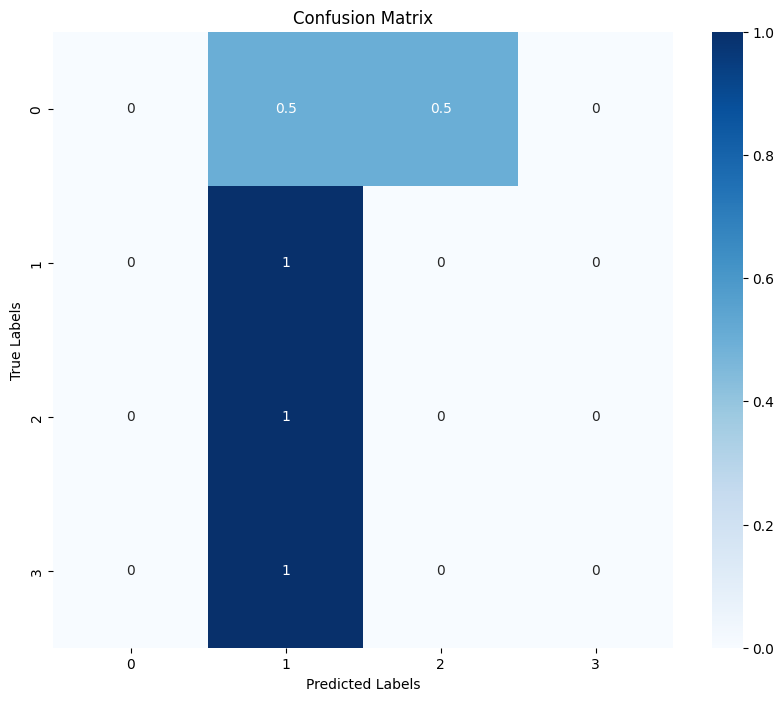

Epoch 4, Validation Loss: 1.9996, Accuracy: 0.1429, F1 Score: 0.0408
Val F1 Score Per Class  [0.         0.28571429 0.         0.        ]


Epoch 5, Train Loss: 0.1826, Accuracy: 0.9728, F1 Score: 0.9729
Train F1 Score Per Class  [0.98181818 0.98550725 0.95238095 0.95774648 0.98245614]


[tensor([-1.5378, -1.2357, -1.9372, -1.3295, -1.4088], device='cuda:0'), tensor([-1.8327, -0.6390, -1.5516, -0.8595, -1.2424], device='cuda:0'), tensor([-1.5981, -1.9530, -1.4173, -1.2669, -1.4509], device='cuda:0'), tensor([-1.6759, -1.2089, -1.9263, -1.1162, -0.6055], device='cuda:0'), tensor([-1.3239,  3.0037, -0.9148, -1.0859, -1.0689], device='cuda:0'), tensor([-2.2443, -1.3877, -1.2742, -0.6581, -1.2115], device='cuda:0'), tensor([-1.7580, -0.6973, -1.7109, -1.2307, -1.2032], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


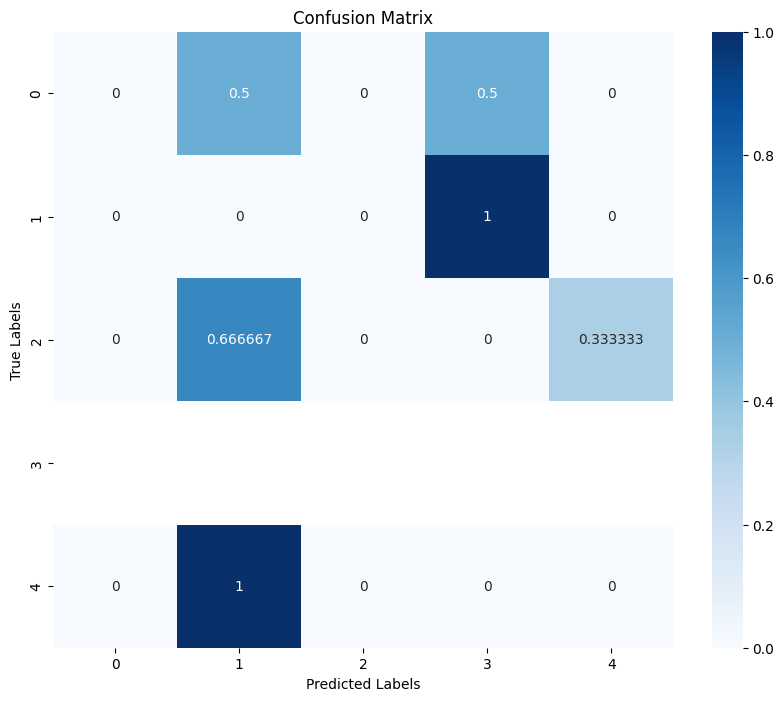

Epoch 5, Validation Loss: 2.3850, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0. 0. 0. 0.]


Epoch 6, Train Loss: 0.1034, Accuracy: 0.9796, F1 Score: 0.9795
Train F1 Score Per Class  [0.98245614 1.         1.         0.95652174 0.96428571]


[tensor([-1.5924, -1.7013, -1.6322, -1.2637, -1.0082], device='cuda:0'), tensor([-2.0264, -1.5323, -1.4711, -0.5232, -1.6122], device='cuda:0'), tensor([-1.6403, -2.0150, -0.8747, -1.1124, -1.5453], device='cuda:0'), tensor([-1.1253, -1.0389, -1.4188, -1.0808,  1.5604], device='cuda:0'), tensor([-1.7334, -0.1296, -1.3297, -0.6445, -1.7114], device='cuda:0'), tensor([-2.2757, -1.4525, -0.8107,  0.8873, -1.5626], device='cuda:0'), tensor([-1.9722, -1.3443, -0.9606, -0.9872, -1.8365], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


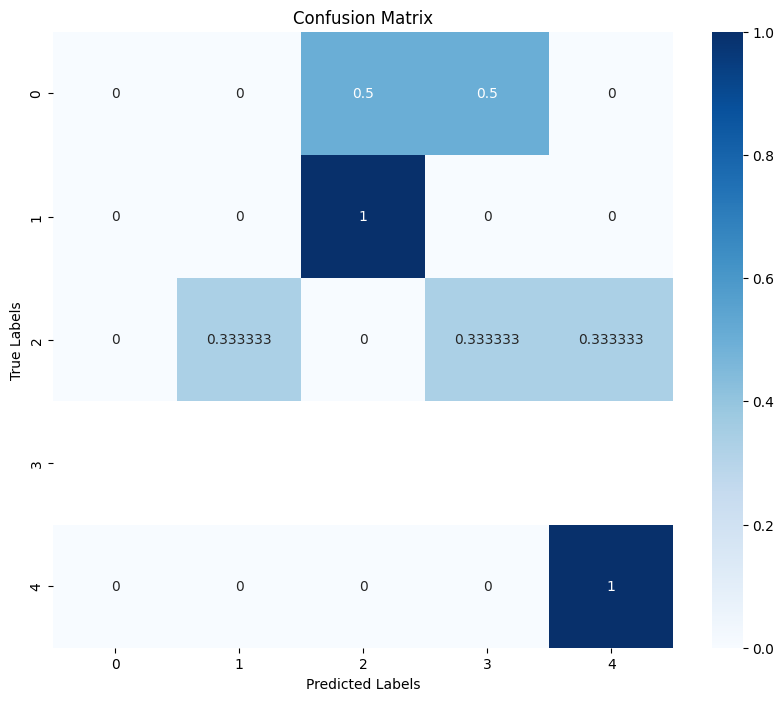

Epoch 6, Validation Loss: 2.3238, Accuracy: 0.1429, F1 Score: 0.0952
Val F1 Score Per Class  [0.         0.         0.         0.         0.66666667]


Epoch 7, Train Loss: 0.3846, Accuracy: 0.9048, F1 Score: 0.9051
Train F1 Score Per Class  [0.88461538 0.92753623 1.         0.86111111 0.88135593]


[tensor([-2.0499, -1.0954, -1.6290, -1.4590, -1.4628], device='cuda:0'), tensor([-1.8817, -0.1279, -1.2798, -1.5894, -1.3106], device='cuda:0'), tensor([-2.0167, -0.5325, -0.6991, -1.3556, -1.6864], device='cuda:0'), tensor([-1.9424, -0.6433, -1.6363, -1.1220, -0.8352], device='cuda:0'), tensor([-0.7517, -0.4582, -1.8084, -0.9051, -1.4141], device='cuda:0'), tensor([-2.3157, -0.9975, -1.2470, -0.6196, -1.6565], device='cuda:0'), tensor([-1.7086,  0.9011, -0.7534, -1.3511, -1.5562], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


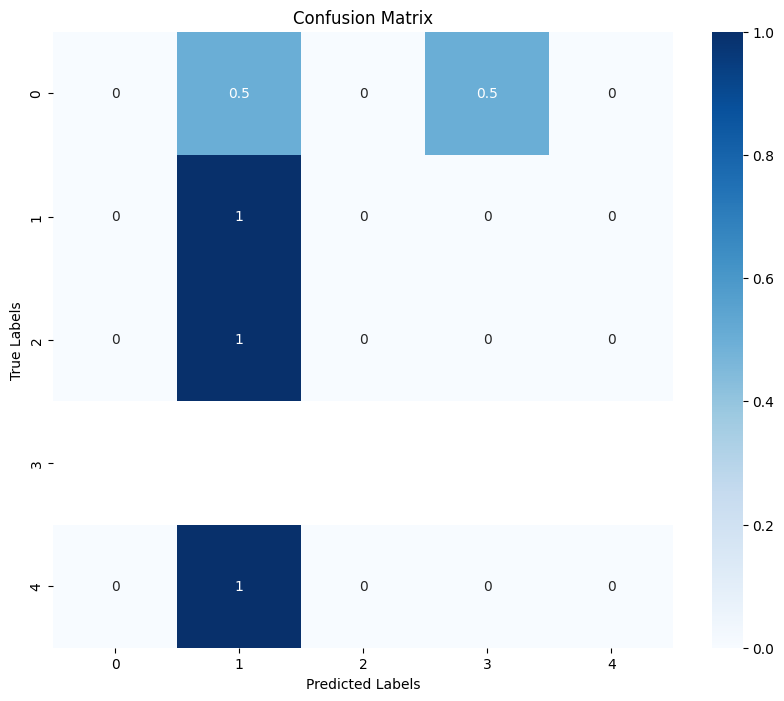

Epoch 7, Validation Loss: 2.1074, Accuracy: 0.1429, F1 Score: 0.0408
Val F1 Score Per Class  [0.         0.28571429 0.         0.         0.        ]


Epoch 8, Train Loss: 0.4577, Accuracy: 0.8503, F1 Score: 0.8484
Train F1 Score Per Class  [0.73076923 0.70422535 0.95238095 0.93150685 0.96428571]


[tensor([-1.0526, -0.6270, -2.0715, -1.4097, -1.4722], device='cuda:0'), tensor([-0.3691, -0.1007, -2.1199, -0.9851, -1.0995], device='cuda:0'), tensor([-0.6950, -0.9642, -1.9405, -0.8486, -1.7279], device='cuda:0'), tensor([-0.9910, -0.9194, -2.2688, -0.3868, -0.6594], device='cuda:0'), tensor([-0.3115,  0.3715, -2.2090, -1.0711, -1.6971], device='cuda:0'), tensor([-1.2880, -0.9931, -1.9551, -0.9106, -1.5404], device='cuda:0'), tensor([-0.2866, -0.2033, -1.9414, -0.5969, -1.4112], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


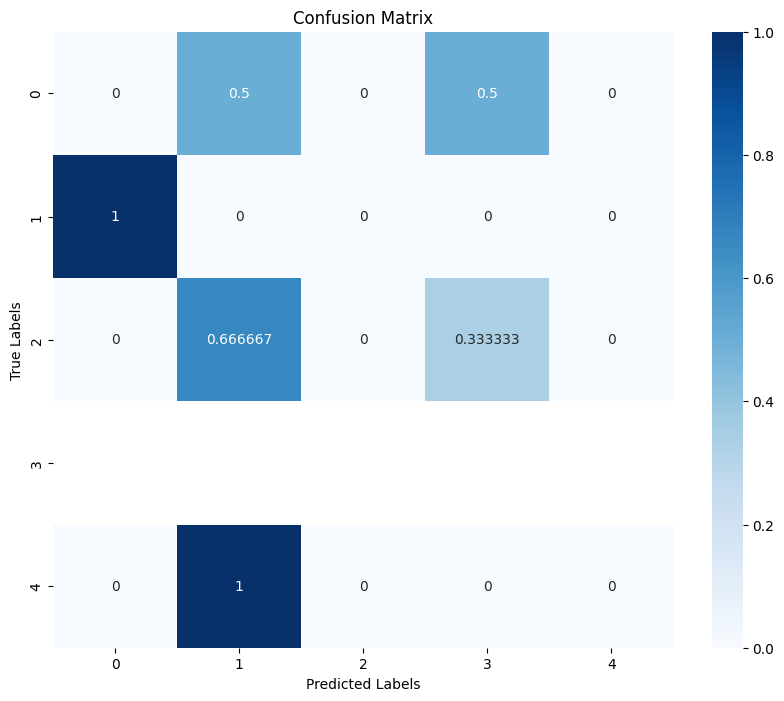

Epoch 8, Validation Loss: 2.1995, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0. 0. 0. 0.]


Epoch 9, Train Loss: 0.1735, Accuracy: 0.9660, F1 Score: 0.9662
Train F1 Score Per Class  [0.96296296 0.94444444 0.97560976 0.95774648 1.        ]


[tensor([-1.7628, -0.6861, -1.7523, -1.6937, -2.0017], device='cuda:0'), tensor([-0.4772, -0.2458, -1.7886, -1.2618, -1.4297], device='cuda:0'), tensor([-1.2973, -1.1370, -1.6953, -1.8049, -1.7891], device='cuda:0'), tensor([-1.7159, -0.7710, -1.9635, -0.9283,  0.3436], device='cuda:0'), tensor([-0.5965, -0.4153, -1.9962, -0.9747, -1.7993], device='cuda:0'), tensor([-1.6568, -0.8416, -1.7873, -0.6947, -1.8260], device='cuda:0'), tensor([-0.9819,  1.0385, -1.0826, -1.7388, -1.8800], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


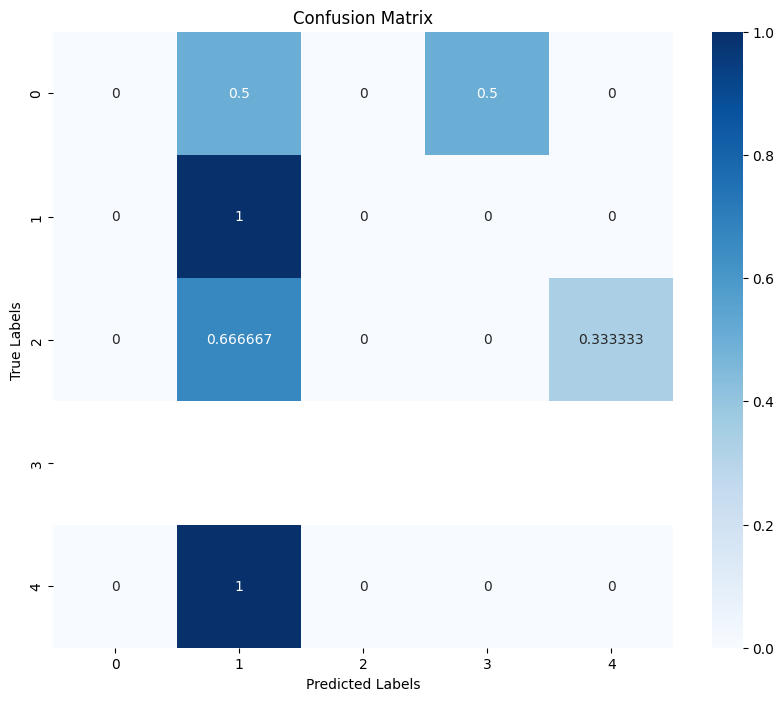

Epoch 9, Validation Loss: 2.2619, Accuracy: 0.1429, F1 Score: 0.0476
Val F1 Score Per Class  [0.         0.33333333 0.         0.         0.        ]


Epoch 10, Train Loss: 0.1255, Accuracy: 0.9796, F1 Score: 0.9797
Train F1 Score Per Class  [1.         0.98550725 0.97674419 0.97058824 0.96551724]


[tensor([-1.6335, -1.0094, -1.8869, -1.7710, -2.4158], device='cuda:0'), tensor([-0.1664, -0.4837, -1.8364, -1.1162, -2.2951], device='cuda:0'), tensor([-1.5481, -0.8827, -1.4703, -2.1377, -2.3848], device='cuda:0'), tensor([-1.8900, -1.2995, -2.1290, -0.5975, -1.0647], device='cuda:0'), tensor([-0.4378, -0.5820, -1.9978, -1.0116, -2.4110], device='cuda:0'), tensor([-1.6839, -0.5857, -0.7220,  1.2227, -2.8528], device='cuda:0'), tensor([-1.5423,  0.8833, -1.3874, -1.7290, -2.8142], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


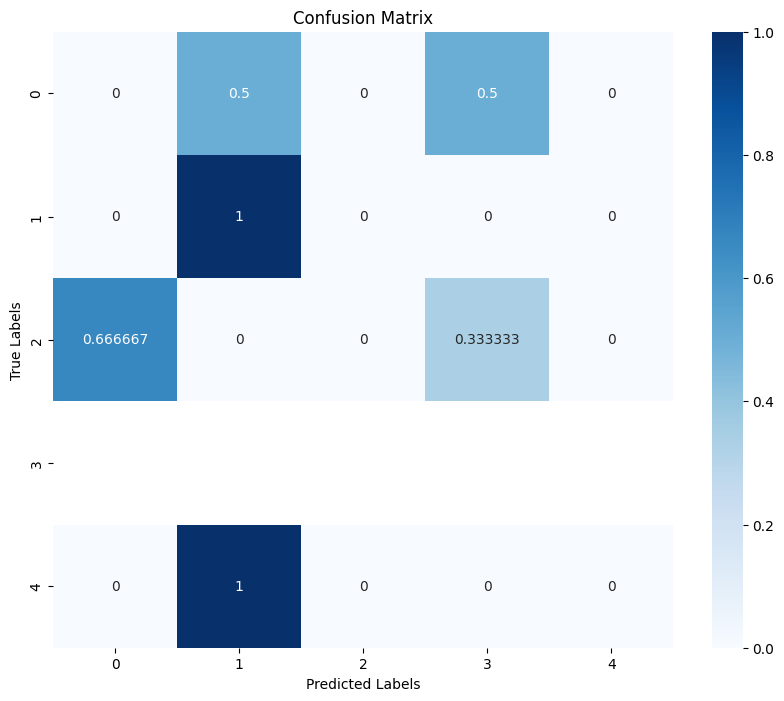

Epoch 10, Validation Loss: 2.4098, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


Epoch 11, Train Loss: 0.0577, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.6039, -1.3630, -1.9370, -1.8590, -2.1069], device='cuda:0'), tensor([-0.3976, -0.5132, -1.9288, -1.3799, -2.0761], device='cuda:0'), tensor([-1.6989, -1.2278, -1.5714, -2.5255, -2.2349], device='cuda:0'), tensor([-2.0157, -1.3577, -2.0911, -0.7813, -0.0835], device='cuda:0'), tensor([-0.5225, -0.4973, -2.0668, -1.1504, -2.3151], device='cuda:0'), tensor([-1.7663, -0.7187, -0.9764,  0.4662, -2.6883], device='cuda:0'), tensor([-1.6629,  0.7864, -1.5955, -2.1387, -2.6506], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


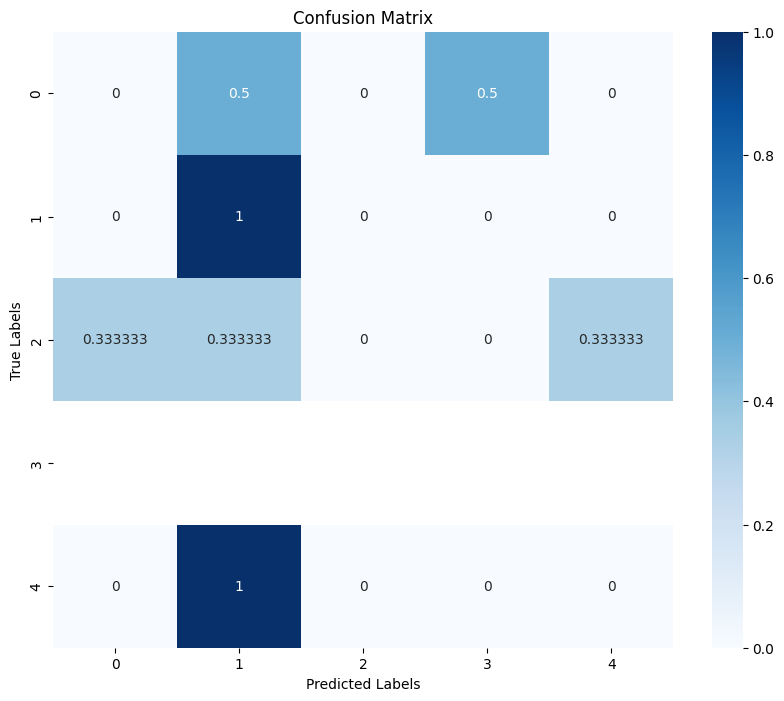

Epoch 11, Validation Loss: 2.3390, Accuracy: 0.1429, F1 Score: 0.0571
Val F1 Score Per Class  [0.  0.4 0.  0.  0. ]


Epoch 12, Train Loss: 0.0471, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5253, -1.6991, -1.9936, -2.0138, -1.9601], device='cuda:0'), tensor([-0.4776, -0.6371, -1.9989, -1.5906, -1.9332], device='cuda:0'), tensor([-1.7071, -1.4384, -1.4615, -2.5319, -2.1909], device='cuda:0'), tensor([-1.7658, -1.4888, -2.0167, -0.8916,  0.5428], device='cuda:0'), tensor([-0.5651, -0.5160, -2.0691, -1.3284, -2.1789], device='cuda:0'), tensor([-1.8715, -0.8705, -1.1455,  0.0665, -2.5962], device='cuda:0'), tensor([-1.7202,  0.2589, -1.6467, -2.3415, -2.5930], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


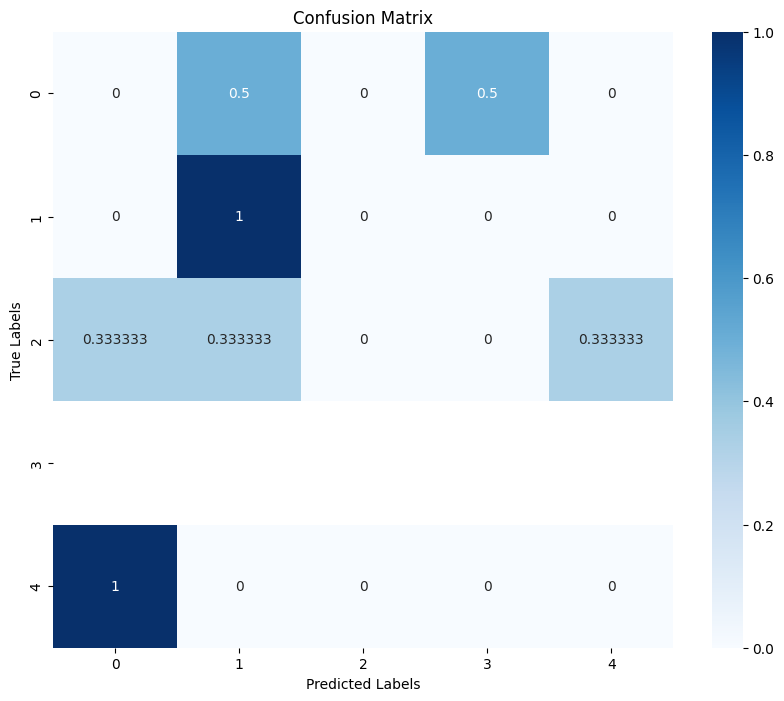

Epoch 12, Validation Loss: 2.2848, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


Epoch 13, Train Loss: 0.0422, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.6086, -1.7200, -2.0608, -1.9415, -1.8210], device='cuda:0'), tensor([-0.6049, -0.6588, -2.0674, -1.4812, -1.8341], device='cuda:0'), tensor([-1.7604, -1.4616, -1.4187, -2.4882, -2.1937], device='cuda:0'), tensor([-1.7596, -1.5364, -2.0147, -0.8380,  0.7092], device='cuda:0'), tensor([-0.6341, -0.5154, -2.1191, -1.3421, -2.1483], device='cuda:0'), tensor([-1.8770, -0.8973, -1.2767,  0.1832, -2.5347], device='cuda:0'), tensor([-1.7495,  0.2824, -1.7384, -2.3415, -2.5420], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


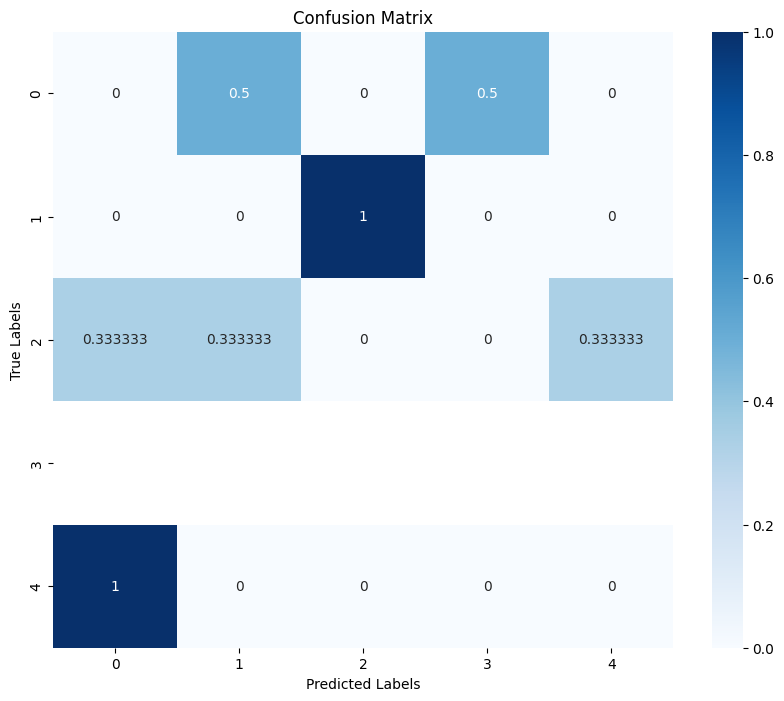

Epoch 13, Validation Loss: 2.3044, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0. 0. 0. 0.]


Epoch 14, Train Loss: 0.0365, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5626, -1.6876, -2.0937, -1.9684, -1.8756], device='cuda:0'), tensor([-0.5992, -0.6348, -2.1085, -1.4800, -1.7976], device='cuda:0'), tensor([-1.7682, -1.4546, -1.4484, -2.5274, -2.2420], device='cuda:0'), tensor([-1.6857, -1.5407, -2.0457, -0.8788,  0.7610], device='cuda:0'), tensor([-0.6360, -0.5162, -2.1405, -1.3549, -2.1188], device='cuda:0'), tensor([-1.8401, -0.8773, -1.3798,  0.0990, -2.5014], device='cuda:0'), tensor([-1.7191,  0.4025, -1.7472, -2.3989, -2.4894], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


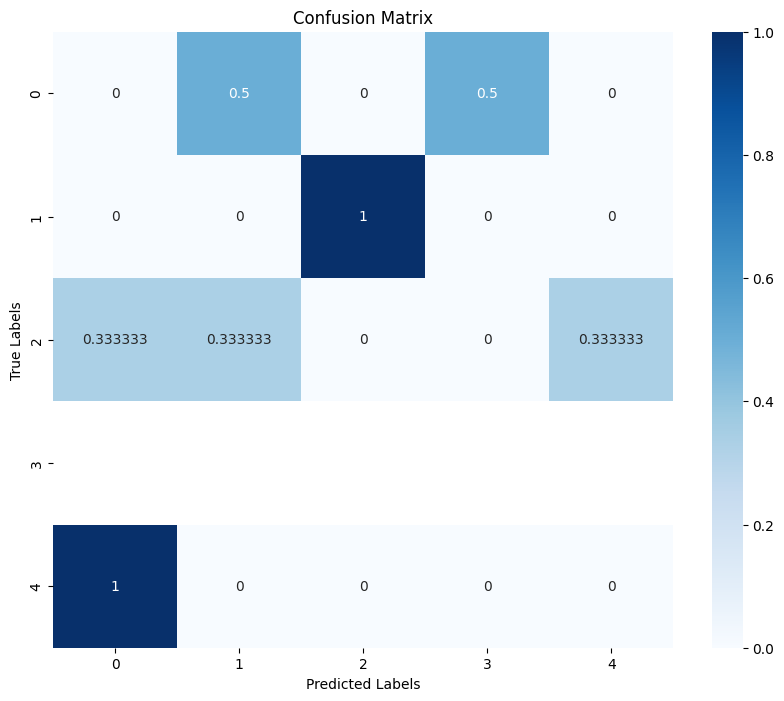

Epoch 14, Validation Loss: 2.3232, Accuracy: 0.0000, F1 Score: 0.0000
Val F1 Score Per Class  [0. 0. 0. 0. 0.]


Epoch 15, Train Loss: 0.0348, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5561, -1.6957, -2.1088, -1.9892, -1.8927], device='cuda:0'), tensor([-0.5944, -0.6380, -2.1263, -1.4715, -1.7963], device='cuda:0'), tensor([-1.7707, -1.4194, -1.4389, -2.5346, -2.2525], device='cuda:0'), tensor([-1.6677, -1.5515, -2.0514, -0.9069,  0.7480], device='cuda:0'), tensor([-0.6449, -0.5239, -2.1551, -1.3554, -2.1058], device='cuda:0'), tensor([-1.8468, -0.8882, -1.4080,  0.0761, -2.5157], device='cuda:0'), tensor([-1.7156,  0.4121, -1.7366, -2.4284, -2.4716], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


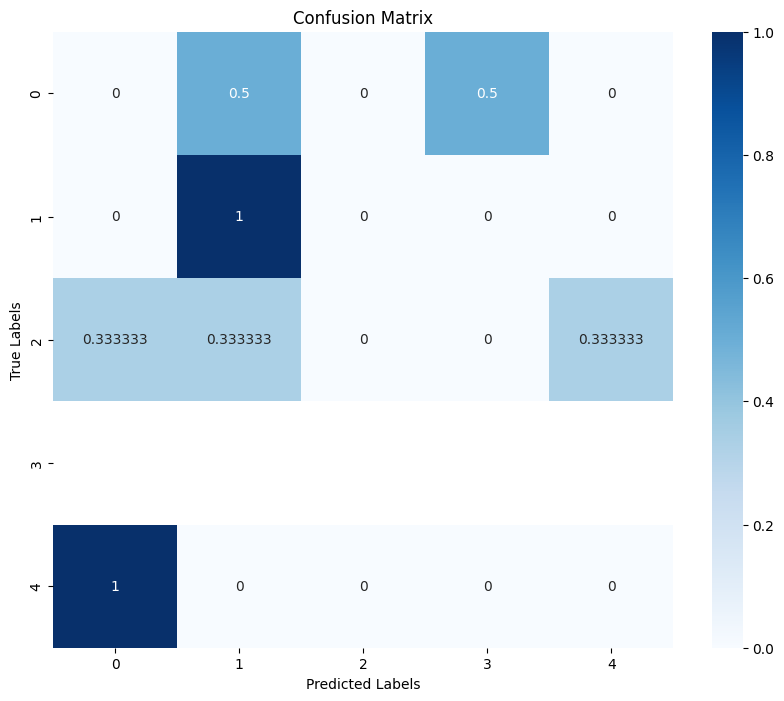

Epoch 15, Validation Loss: 2.3224, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


Epoch 16, Train Loss: 0.0336, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5608, -1.6870, -2.1032, -1.9933, -1.9283], device='cuda:0'), tensor([-0.5980, -0.6339, -2.1270, -1.4612, -1.8246], device='cuda:0'), tensor([-1.7667, -1.3949, -1.4217, -2.5082, -2.2643], device='cuda:0'), tensor([-1.6722, -1.5674, -2.0593, -0.9264,  0.6681], device='cuda:0'), tensor([-0.6526, -0.5288, -2.1531, -1.3561, -2.1121], device='cuda:0'), tensor([-1.8480, -0.8944, -1.4129,  0.0647, -2.5281], device='cuda:0'), tensor([-1.7163,  0.4018, -1.6906, -2.4310, -2.4788], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


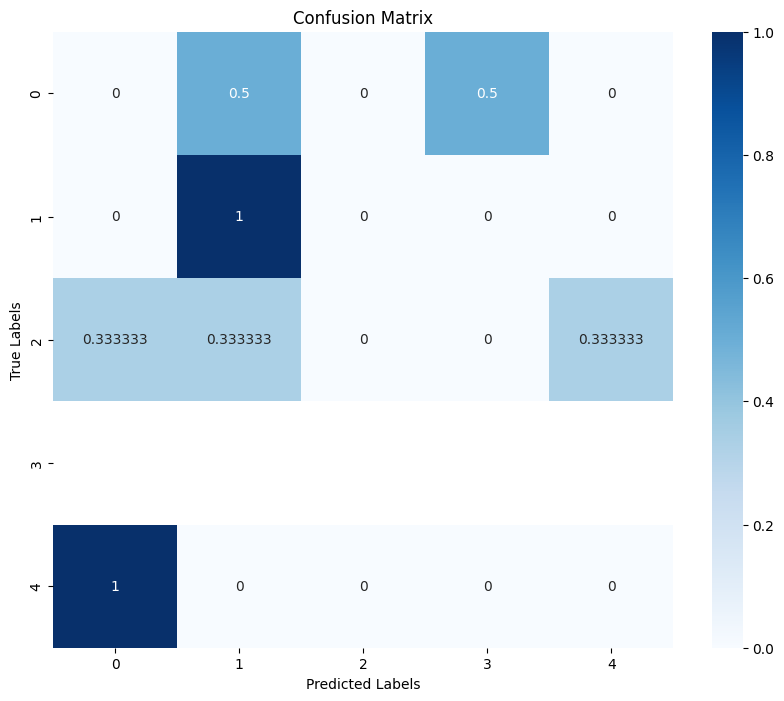

Epoch 16, Validation Loss: 2.3152, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


Epoch 17, Train Loss: 0.0325, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5669, -1.6858, -2.1074, -1.9980, -1.9429], device='cuda:0'), tensor([-0.6028, -0.6422, -2.1292, -1.4594, -1.8336], device='cuda:0'), tensor([-1.7702, -1.3890, -1.4160, -2.5086, -2.2679], device='cuda:0'), tensor([-1.6698, -1.5728, -2.0581, -0.9382,  0.6492], device='cuda:0'), tensor([-0.6590, -0.5350, -2.1539, -1.3613, -2.1123], device='cuda:0'), tensor([-1.8544, -0.9047, -1.4149,  0.0690, -2.5337], device='cuda:0'), tensor([-1.7208,  0.3784, -1.6865, -2.4396, -2.4660], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


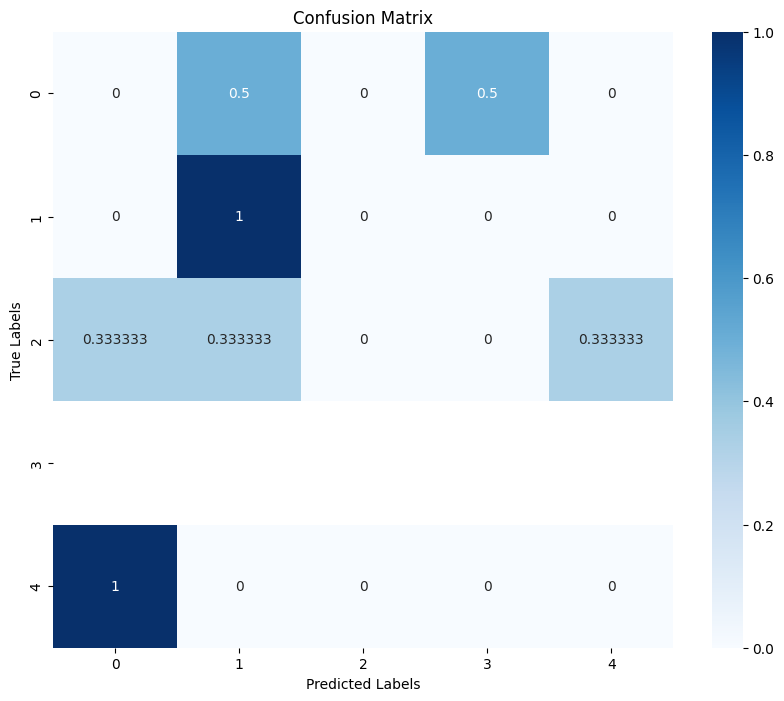

Epoch 17, Validation Loss: 2.3117, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


Epoch 18, Train Loss: 0.0325, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5681, -1.6876, -2.1134, -2.0007, -1.9494], device='cuda:0'), tensor([-0.6067, -0.6472, -2.1313, -1.4576, -1.8336], device='cuda:0'), tensor([-1.7714, -1.3853, -1.4130, -2.5104, -2.2703], device='cuda:0'), tensor([-1.6663, -1.5757, -2.0561, -0.9417,  0.6522], device='cuda:0'), tensor([-0.6629, -0.5384, -2.1564, -1.3634, -2.1129], device='cuda:0'), tensor([-1.8576, -0.9099, -1.4188,  0.0697, -2.5332], device='cuda:0'), tensor([-1.7225,  0.3683, -1.6908, -2.4444, -2.4585], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


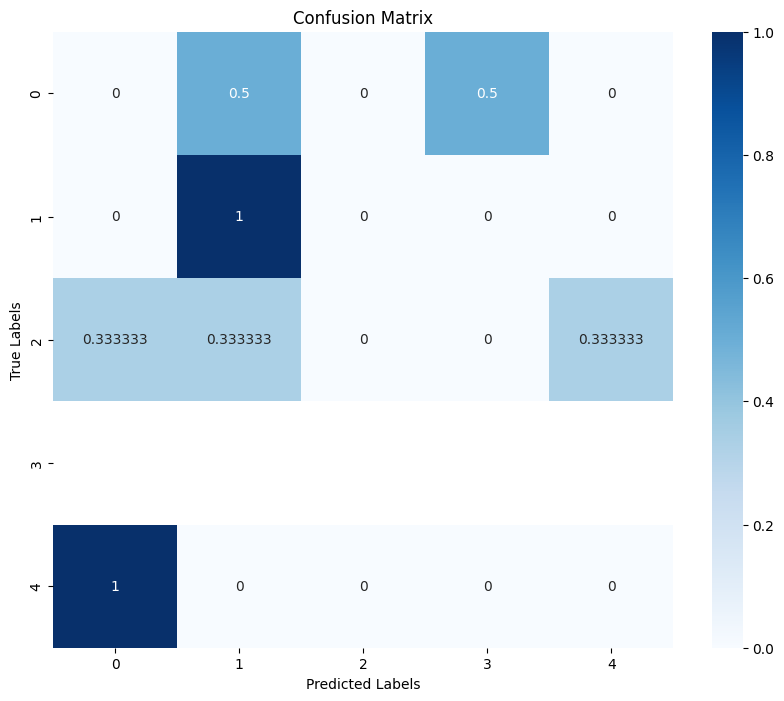

Epoch 18, Validation Loss: 2.3110, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


Epoch 19, Train Loss: 0.0325, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5696, -1.6868, -2.1129, -1.9998, -1.9536], device='cuda:0'), tensor([-0.6090, -0.6488, -2.1319, -1.4550, -1.8365], device='cuda:0'), tensor([-1.7721, -1.3847, -1.4118, -2.5080, -2.2721], device='cuda:0'), tensor([-1.6676, -1.5785, -2.0580, -0.9422,  0.6450], device='cuda:0'), tensor([-0.6654, -0.5399, -2.1574, -1.3629, -2.1154], device='cuda:0'), tensor([-1.8586, -0.9110, -1.4198,  0.0697, -2.5347], device='cuda:0'), tensor([-1.7230,  0.3662, -1.6924, -2.4435, -2.4589], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


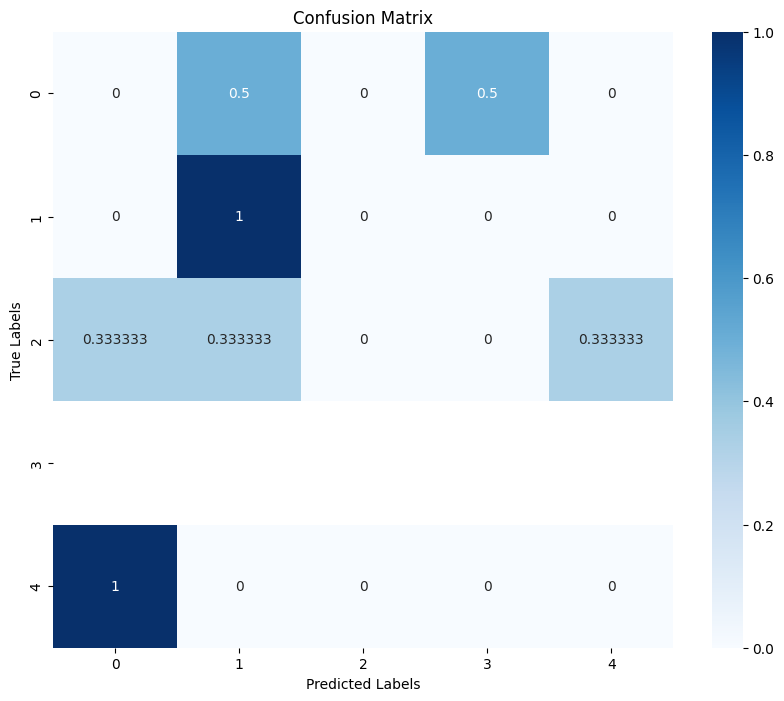

Epoch 19, Validation Loss: 2.3106, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


Epoch 20, Train Loss: 0.0334, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1.]


[tensor([-1.5689, -1.6856, -2.1111, -2.0009, -1.9568], device='cuda:0'), tensor([-0.6094, -0.6484, -2.1317, -1.4549, -1.8382], device='cuda:0'), tensor([-1.7721, -1.3843, -1.4110, -2.5074, -2.2731], device='cuda:0'), tensor([-1.6674, -1.5786, -2.0586, -0.9440,  0.6365], device='cuda:0'), tensor([-0.6658, -0.5401, -2.1569, -1.3637, -2.1169], device='cuda:0'), tensor([-1.8589, -0.9108, -1.4206,  0.0658, -2.5353], device='cuda:0'), tensor([-1.7228,  0.3664, -1.6922, -2.4440, -2.4594], device='cuda:0')]


/tmp/ipykernel_91837/3428606769.py:123: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


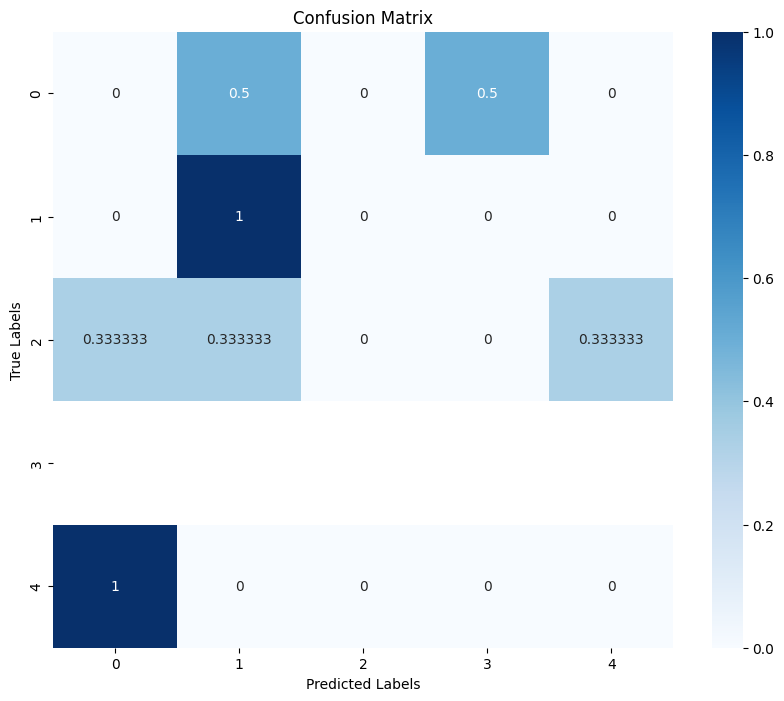

Epoch 20, Validation Loss: 2.3098, Accuracy: 0.1429, F1 Score: 0.0714
Val F1 Score Per Class  [0.  0.5 0.  0.  0. ]


[tensor([-1.9258, -1.2251, -0.8720, -1.2811, -1.0493], device='cuda:0'), tensor([-1.2595, -1.4004, -2.0543, -2.2147, -0.7019], device='cuda:0'), tensor([-1.7634, -0.8007, -2.5199, -1.4647, -2.0660], device='cuda:0'), tensor([-0.8099, -1.4198, -2.1957, -1.9312, -0.1589], device='cuda:0'), tensor([-1.8202, -0.7865, -1.2036, -2.7096, -2.7736], device='cuda:0'), tensor([-1.6170, -1.2177, -2.2798, -1.0410, -2.0304], device='cuda:0'), tensor([-1.6700, -1.1911, -2.2132, -2.3215, -1.8727], device='cuda:0'), tensor([-0.9935, -1.8771, -1.6732, -2.2131, -1.0028], device='cuda:0')]


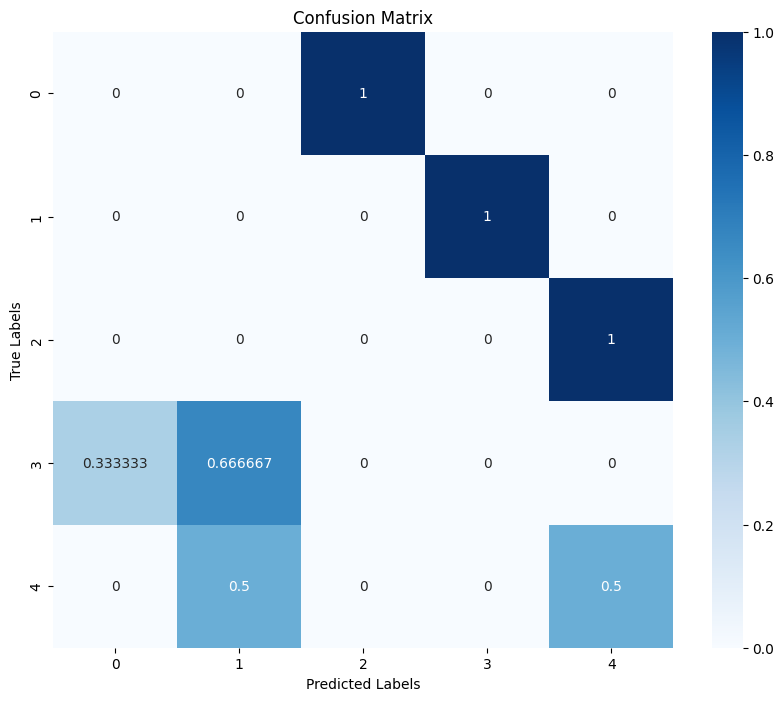

Test Loss: 2.028, Accuracy: 0.125, F1 Score: 0.125, F1 Score Per Class [0.000
Test F1 Score Per Class  [0.  0.  0.  0.  0.5]


In [22]:
# Call the main function with the path to folder1
# imagesRoot = '/kaggle/input/dummydataset/'
imagesRoot = '../Data/DummyData'

path_to_images = imagesRoot 
train_loader, val_loader, test_loader = load_data(path_to_images)

def load_pretrained_vit(num_labels):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_labels)
    return model

num_classes = 5  # Adjust as per your dataset
num_epochs = 20
# Load the pretrained ResNet-50 model
# model = models.resnet50(pretrained=True)
vit_model = load_pretrained_vit(num_labels=num_classes)

# model.fc = nn.Linear(model.fc.in_features, num_classes)
# Initialize best F1 score for validation

best_val_f1 = 0.0
best_model_weights = None
model_name = 'TreesDelftV001'
trained_model = train_and_evaluate(vit_model, train_loader, val_loader, test_loader, model_name, num_epochs)

Test:   0%|          | 0/1 [00:00<?, ?it/s]

[tensor([-1.9258, -1.2251, -0.8720, -1.2811, -1.0493], device='cuda:0'), tensor([-1.2595, -1.4004, -2.0543, -2.2147, -0.7019], device='cuda:0'), tensor([-1.7634, -0.8007, -2.5199, -1.4647, -2.0660], device='cuda:0'), tensor([-0.8099, -1.4198, -2.1957, -1.9312, -0.1589], device='cuda:0'), tensor([-1.8202, -0.7865, -1.2036, -2.7096, -2.7736], device='cuda:0'), tensor([-1.6170, -1.2177, -2.2798, -1.0410, -2.0304], device='cuda:0'), tensor([-1.6700, -1.1911, -2.2132, -2.3215, -1.8727], device='cuda:0'), tensor([-0.9935, -1.8771, -1.6732, -2.2131, -1.0028], device='cuda:0')]


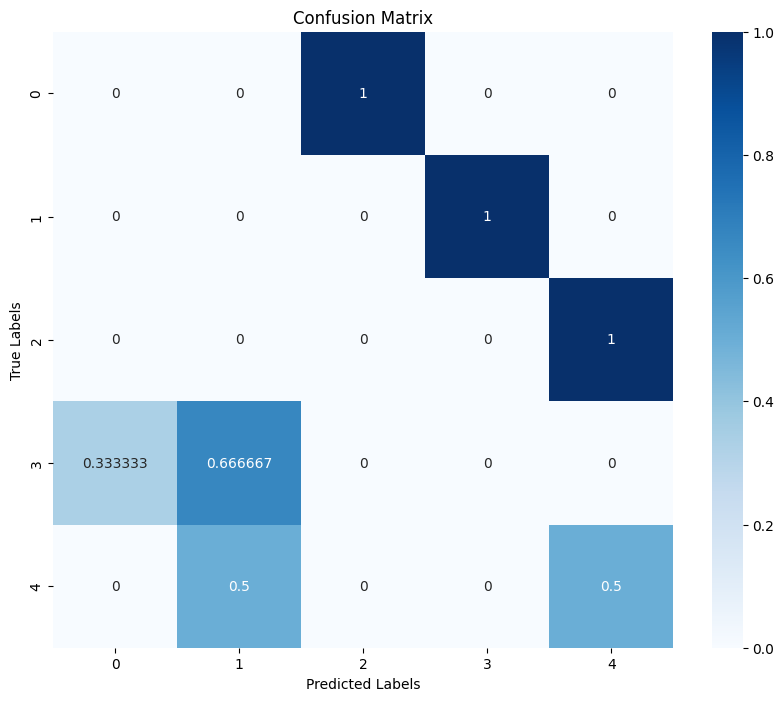

Test Loss: 2.028, Accuracy: 0.125, F1 Score: 0.125, F1 Score Per Class [0.000
Test F1 Score Per Class  [0.  0.  0.  0.  0.5]


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
patch_size=(224, 224)
stride=30
test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(trained_model, test_loader, criterion, device, patch_size, stride, desc='Test')
print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
print(f'Test F1 Score Per Class ', test_f1_per_class)